In [1]:
import astropy
import numpy as np
import pandas as pd
import matplotlib
import scipy

from astropy.io import fits
from astropy.wcs import WCS
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter 
from scipy import stats

In [2]:
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['text.color'] = 'Black'
plt.rcParams['font.size'] = '14'
plt.rcParams['figure.figsize'] = (9, 6)

In [3]:
GASKAP = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/LMC_30Dor_fg/the actual cube!.fits')
GASKAP[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -32 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 3191                                                  
NAXIS2  =                 2681                                                  
NAXIS3  =                  301                                                  
BLANK   =                   -1  /                                               
BUNIT   = 'K       '                                                            
DATE-OBS= '2021-10-27T16:16:57.5'  /                                            
TELESCOP= 'ASKAP   '  /                                                         
CRPIX1  =    1.70200000000E+03  /                                               
CDELT1  =   -1.94444444444E-03  /                                               
CRVAL1  =    8.32511958333E+

In [4]:
HI4PI = fits.open('/Users/FRANNYPACK/Downloads/grind!/research/Data/LMC_HI4PI/mosaic_cube.fits')
HI4PI[0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    3 / number of array dimensions                     
NAXIS1  =                 3191                                                  
NAXIS2  =                 2681                                                  
NAXIS3  =                   71                                                  
CRPIX1  =               1702.0                                                  
CRPIX2  =               1352.0                                                  
CRPIX3  =      39.921630003202                                                  
CRVAL1  =        83.2511958333                                                  
CRVAL2  =       -69.8577944444                                                  
CRVAL3  =                  0.0                                                  
CDELT1  =    -0.001944444444

In [5]:
# H2 adsorbers w/h central velocities
FUSE = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_H2_components.csv')
FUSE = FUSE[(FUSE["DEC"] < -67.5) & (FUSE["RA"] > 75)] # relevant stars in LMC

In [6]:
# H2 adsorbers w/o central velocities
FUSE_no_v = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/FUSE_info (SMC + LMC).csv')
FUSE_no_v = FUSE_no_v[(FUSE_no_v["DEC_FK5"] < -67.5) & (FUSE_no_v["RA_FK5"] > 75)]

In [7]:
# using velocities of C/Cl to substitute in for H2
other_elem = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/MW_H2_other_elem.csv')
other_elem = other_elem[(other_elem["DEC"] < -67.5) & (other_elem["galaxy_field"] == 'LMC') & (other_elem["RA"] > 75)]

# RELEVANT FUNCTIONS

In [133]:
# FOR HI4PI

def v_indx(v_val): # v_val must be in m/s
    return int((v_val - -51220.42315311206) / (1288.21496912415))

In [103]:
# FOR GASKAP

def v_indx_GASKAP(v_val): # v_val must be in m/s
    v_indx = int((v_val - (3.04208717990 * 10 ** 4)) / (-2.44297870185 * 10 ** 2))
    return v_indx

In [9]:
# make 2D header 

def make_flat_hdr(file):
    hdr = file[0].header
    
    # Make a 2D header 
    flathdr = fits.Header()
    flathdr["NAXIS   "] = 2
    flathdr["NAXIS1  "] = hdr["NAXIS1  "]
    flathdr["NAXIS2  "] = hdr["NAXIS2  "]
    flathdr["CRPIX1  "] = hdr["CRPIX1  "]
    flathdr["CRPIX2  "] = hdr["CRPIX2  "]
    flathdr["CRVAL1  "] = hdr["CRVAL1  "]
    flathdr["CRVAL2  "] = hdr["CRVAL2  "]
    flathdr["CDELT1  "] = hdr["CDELT1  "]
    flathdr["CDELT2  "] = hdr["CDELT2  "]
    flathdr["CTYPE1  "] = hdr["CTYPE1  "]
    flathdr["CTYPE2  "] = hdr["CTYPE2  "]
    flathdr["LONPOLE "] = hdr["LONPOLE "]
    flathdr["LATPOLE "] = hdr["LATPOLE "]
    
    return flathdr

In [10]:
# gives pix vals associated w RA/DEC vals

def pix_vals(flat_FITS_hdr, ra_values, dec_values):
    wcs = WCS(flat_FITS_hdr)
    pix_arr = []
    x_pix = []
    y_pix = []
    for i in range(0, len(ra_values)):
        arr = []
        x_pix, y_pix = wcs.all_world2pix(ra_values[i], dec_values[i], 0)
        arr.append(x_pix)
        arr.append(y_pix)
        pix_arr.append(arr)
    
    return pix_arr

In [108]:
# HI column density values aligning with H2 background stars

def col_dens_arr(pix_arr, col_dens_vals, log = True):
    HI_col_dens = np.zeros(len(pix_arr))
    HI_col_dens_nolog = np.zeros(len(pix_arr))
    for i in range(len(pix_arr)):
        # RA values = 0, Dec = 1 BUT the rows in col_dens_vals = y-values, cols = x-values
        col_dens = col_dens_vals[int(pix_arr[i][1])][int(pix_arr[i][0])] 
        # so the values are logarithmic (to match H2 col dens) and in cm^-2
        HI_col_dens_nolog[i] = col_dens
        HI_col_dens[i] = np.log10(col_dens)
    
    if log:
        return HI_col_dens
    else:
        return HI_col_dens_nolog

In [471]:
# does the actual work of the USM

def process_usm(cc_sum, FWHM = 30., file = HI4PI, low = False):
    
    pix_len = file[0].header['CDELT2'] * 60 # ['CDELT2'] = pixel length in deg, multiply by 60 to convert to arcmin
    FWHM30_pix = FWHM / pix_len # want FWHM to be 30 arcmin, so convert to pixels
    sigma = FWHM30_pix / (2 * np.sqrt(2 * np.log(2))) # converts from FWHM to sigma, since Gaussian filter specified by sigma
    sum_smooth = gaussian_filter(cc_sum, sigma = sigma) # does smoothing using Gaussian filter
    
    if low:
        sum_USM = sum_smooth
    else:
        sum_USM = cc_sum - sum_smooth
    
    return sum_USM


In [387]:
# for multiple channel maps
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_cd(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 3) # 3 km/s = 3 maps at a time    
    tot_cd = np.zeros((2681, 3191))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder that we have to integrate over
            if ((v_indx_max - v_indx_min) % 3 == 0): # nothing left to integrate over - we done!
                tot_cd[np.where(tot_cd < 0.)] = 0.
                return tot_cd
            else:
                cd_arr = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[cur:v_indx_max], axis = 0) * (1288.2149691242 * 10 ** -3)
        else: 
            cd_arr = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[cur:cur + 3], axis = 0) * (1288.2149691242 * 10 ** -3)
        
        if maskb:
            cd_arr = mask_border(cd_arr)
            
        tot_cd += process_usm(cd_arr, FWHM = FWHM)
        cur += 3

    tot_cd[np.where(tot_cd < 0.)] = 0. # at end so negative noise cancels out with positive noise
    return tot_cd

In [473]:
# for multiple channel maps
# computes unsharp mask over 3 km/s at a time, then adds them up (so as to not wash out the small-scale structure)

def usm_cd_GASKAP(v_indx_min, v_indx_max, FWHM = 30., maskb = False):
    cur = v_indx_min
    num_iterations = int((v_indx_max - v_indx_min) / 12) # 3 km/s = 12 maps at a time
    tot_cd = np.zeros((2681, 3191))
    
    for i in range(num_iterations + 1):
        if (i == num_iterations): # remainder of 12 that we have to integrate over
            if ((v_indx_max - v_indx_min) % 12 == 0): # nothing left to integrate over - we done!
                tot_cd[np.where(tot_cd < 0)] = 0 # cancelling noise
                return tot_cd
            else:
                cd_arr = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[cur:v_indx_max], axis = 0) * 0.244297870185
        else: 
            cd_arr = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[cur:cur + 12], axis = 0) * 0.244297870185
        
        if maskb:
            cd_arr = mask_border(cd_arr)
            
        cd_arr = process_usm(cd_arr, FWHM = FWHM, file = GASKAP) # high-pass filtering large-scale structure
        cd_arr = process_usm(cd_arr, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering so resolution matches HI4PI
        tot_cd += cd_arr
        cur += 12

    tot_cd[np.where(tot_cd < 0)] = 0 # at end so negative noise cancels out with positive noise
    return tot_cd

In [13]:
def show_usm(cd, vmin = 0, vmax = 0):
    plt.figure(figsize = (15, 9))
    plt.imshow(np.flip(np.abs(cd), axis = 0), cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

In [225]:
# uses all H2 measurements from FUSE 
# = more data points, but some small-scale structure lost due to integration over channel maps
# only works when working with multiple HI channel maps

def HI_H2_integrated(HI_cd_all, HI_cd_all_GASKAP, SS = True, LS = True, xlim = 0, log10 = True):
    
    # using larger catalogue w/o velocities
    FUSE = pd.read_csv('/Users/FRANNYPACK/Downloads/grind!/research/Data/FUSE_info (SMC + LMC).csv')
    FUSE = FUSE[(FUSE["DEC_FK5"] < -67.5) & (FUSE["Galaxy"] == 'LMC') & (FUSE["RA_FK5"] > 75)]
    FUSE = np.array(FUSE['log10_N_MW'])
    
    HI_cd_pix = np.zeros(len(pix_arr))
    HI_cd_pix_GASKAP = np.zeros(len(pix_arr))
    for i in range(len(pix_arr)):
        if log10:
            HI_cd_pix[i] = np.log10(HI_cd_all[int(pix_arr[i][1])][int(pix_arr[i][0])])
            HI_cd_pix_GASKAP[i] = np.log10(HI_cd_all_GASKAP[int(pix_arr[i][1])][int(pix_arr[i][0])])
        else:
            HI_cd_pix[i] = HI_cd_all[int(pix_arr[i][1])][int(pix_arr[i][0])]
            HI_cd_pix_GASKAP[i] = HI_cd_all_GASKAP[int(pix_arr[i][1])][int(pix_arr[i][0])]
        
    if xlim != 0:
        FUSE = np.delete(FUSE, np.where(HI_cd_pix < xlim))
        HI_cd_pix = np.delete(HI_cd_pix, np.where(HI_cd_pix < xlim))
        
    fig, (ax1, ax2) = plt.subplots(1,2, constrained_layout = True, sharey = True)
    ax1.scatter(HI_cd_pix, FUSE)
    ax2.scatter(HI_cd_pix_GASKAP, FUSE)
    ax1.set_title('HI4PI')
    ax2.set_title('GASKAP')
    
    if SS:
        plt.xlabel('HI Small-Scale Column Densities')
    elif LS:
        plt.xlabel('HI Large-Scale Column Densities')
    else:
        plt.xlabel('HI Total Column Densities')
    ax1.set_ylabel('$H_2$ Column Densities')
    
    return HI_cd_pix, HI_cd_pix_GASKAP, stats.spearmanr(HI_cd_pix, FUSE, nan_policy = 'omit'), stats.spearmanr(HI_cd_pix_GASKAP, FUSE, nan_policy = 'omit')


In [504]:
# returns array to plot HI VS H2 when HI is within +/- 3 km/s of the H2 (or C/Cl velocity)

def HI_H2_one(SS = True, LS = True, log10 = True):
    HI_cd_pix = np.zeros(len(pix_arr2))
    HI_cd_pix_GASKAP = np.zeros(len(pix_arr2))
    
    for i in range(len(FUSE_replaced)):
        v_indx1G = v_indx_GASKAP((FUSE_replaced['vcen'].iloc[i] + 3) * 10 ** 3) 
        v_indx2G = v_indx_GASKAP((FUSE_replaced['vcen'].iloc[i] - 3) * 10 ** 3) 
        v_indx1 = v_indx((FUSE_replaced['vcen'].iloc[i] - 3) * 10 ** 3) # HI4PI
        v_indx2 = v_indx((FUSE_replaced['vcen'].iloc[i] + 3) * 10 ** 3) # HI4PI
        
        if (SS == False) and (LS == False): # using total HI CD instead
            HI_cd_all = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[v_indx1:v_indx2,:,:], axis = 0) * (1288.2149691242 * 10 ** -3)
            HI_cd_all_GASKAP = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx1G:v_indx2G,:,:], axis = 0) * 0.244297870185
            HI_cd_all_GASKAP = process_usm(HI_cd_all_GASKAP, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering so resolution matches HI4PI
        else:
            HI_cd_all = usm_cd(v_indx1, v_indx2) # small-scale structure
            HI_cd_all_GASKAP = usm_cd_GASKAP(v_indx1G, v_indx2G)

        if (SS == False) and (LS == True): # using large-scale HI column density values instead
            HI_cd_tot = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[v_indx1:v_indx2,:,:], axis = 0) * (1288.2149691242 * 10 ** -3) # total column density
            HI_cd_all = HI_cd_tot - HI_cd_all
                
            HI_cd_tot_GASKAP = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx1G:v_indx2G,:,:], axis = 0) * 0.244297870185
            HI_cd_tot_GASKAP = process_usm(HI_cd_tot_GASKAP, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering so resolution matches HI4PI
            HI_cd_all_GASKAP = HI_cd_tot_GASKAP - HI_cd_all_GASKAP
                
        if log10:
            HI_cd_pix[i] = np.log10(HI_cd_all[int(pix_arr2[i][1])][int(pix_arr2[i][0])])
            HI_cd_pix_GASKAP[i] = np.log10(HI_cd_all_GASKAP[int(pix_arr2[i][1])][int(pix_arr2[i][0])])
        else:
            HI_cd_pix[i] = HI_cd_all[int(pix_arr2[i][1])][int(pix_arr2[i][0])]
            HI_cd_pix_GASKAP[i] = HI_cd_all_GASKAP[int(pix_arr2[i][1])][int(pix_arr2[i][0])]

    return HI_cd_pix, HI_cd_pix_GASKAP
        

In [100]:
# plots total column density

def col_dens(arr, vmin, vmax, title, subtitle):
    wcs = WCS(HI4PI[0].header)
    ax = plt.subplot(projection = wcs, slices = ['x','y',1], zorder = -1)
    plt.grid(b = True, which = 'major', axis = 'both', linewidth = 1, color = 'white')
    plt.xlabel('Right Ascension', fontsize = 20)
    plt.ylabel('Declination', fontsize = 20)
    plt.title(title, y = 1.06, fontsize = 22)
    plt.suptitle(subtitle, x = 0.45, y = 0.93, fontsize = 12)
    plt.imshow(arr, cmap = 'magma', vmin = vmin, vmax = vmax)
    plt.colorbar()

# BASIC PARAMETERS

In [19]:
HI4PI_flat_hdr = make_flat_hdr(HI4PI)

In [20]:
x_col = FUSE_no_v['RA_FK5']
y_col = FUSE_no_v['DEC_FK5']
brightness = FUSE_no_v['log10_N_MW']

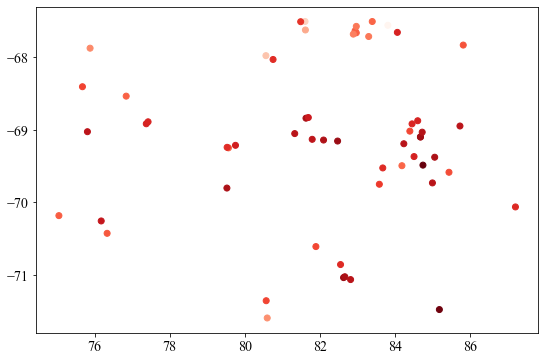

In [21]:
scatter_pts = plt.scatter(x_col, y_col, c = brightness, cmap = 'Reds')
ra_vals = scatter_pts.get_offsets()[:,0]
dec_vals = scatter_pts.get_offsets()[:,1]

In [23]:
pix_arr = pix_vals(HI4PI_flat_hdr, ra_vals, dec_vals)

In [24]:
# rearranging table into arrays for combined C/CI values

other_elem_v = [] # holds (averaged, if necessary) velocities of C/CI
other_elem_stars = [] # holds names of corresponding stars
other_elem_RA = [] # holds corresponding RA values
other_elem_DEC = [] # holds corresponding DEC values

for i in range(len(other_elem)):
    used = True # using current row of elem
    if (np.isnan(other_elem['C_I_vcen'].iloc[i]) == False) & (np.isnan(other_elem['Cl_I_vcen'].iloc[i]) == False):
        other_elem_v.append(np.mean([other_elem['C_I_vcen'].iloc[i], other_elem['Cl_I_vcen'].iloc[i]]))
    elif (np.isnan(other_elem['C_I_vcen'].iloc[i]) == False):
        other_elem_v.append(other_elem['C_I_vcen'].iloc[i])
    elif (np.isnan(other_elem['Cl_I_vcen'].iloc[i]) == False):
        other_elem_v.append(other_elem['Cl_I_vcen'].iloc[i])
    else:
        used = False
        
    if used == True: 
        other_elem_RA.append(other_elem['RA'].iloc[i])
        other_elem_DEC.append(other_elem['DEC'].iloc[i])
        other_elem_stars.append(other_elem['star'].iloc[i])

In [25]:
# replaces central velocities of H2 which have better C/Cl measurements, and deletes those which do not
FUSE_replaced = FUSE 
i = 0
while i < len(FUSE_replaced):
    if FUSE_replaced['star'].iloc[i] in other_elem_stars:
        indx = FUSE_replaced['star'].iloc[i]
        FUSE_replaced['vcen'].iloc[i] = other_elem_v[other_elem_stars.index(indx)]
        other_elem_v.pop(other_elem_stars.index(indx))
        other_elem_stars.pop(other_elem_stars.index(indx))
    else:
        FUSE_replaced = FUSE_replaced.drop(FUSE_replaced.index[i])
        i -= 1
    i += 1

/Users/FRANNYPACK/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [474]:
len(FUSE_replaced)

25

In [27]:
FUSE_replaced

star   vcen         RA        DEC  total_log10_N
50          BI173   4.85  81.792000 -69.132278      18.918631
51          BI184  10.15  82.627500 -71.042022      19.257570
54          BI253   3.90  84.393708 -69.019389      17.263305
57         Brey26   5.80  80.593750 -71.599444      15.331485
61       HD269445   6.60  80.749458 -68.029611      18.117527
62       HD269810   3.30  83.808000 -67.557500      14.876466
68        HD37680   6.75  83.580792 -69.752778      18.331363
73      HDE269927   2.05  84.742708 -69.488639      19.580288
90   MACHO79-4779  -7.25  77.371250 -68.917500      18.334891
91           Mk42   6.25  84.675417 -69.098528      19.081478
116     SK-67D101   5.35  81.484833 -67.507972      18.476032
119     SK-67D108   3.25  81.611042 -67.622306      15.814714
124     SK-67D167   7.85  82.966583 -67.661417      16.239038
125     SK-67D168   7.00  82.967083 -67.572444      16.874274
126     SK-67D191   7.65  83.392167 -67.505444      16.137561
130     SK-68D135   6.50  84.452500 -68.918889      18.424425
134      SK-68D52  -0.90  76.835833 -68.536000      17.985699
137     SK-69D104 -36.00  79.748208 -69.215194      15.422913
138     SK-69D104   5.30  79.748208 -69.215194      18.638401
140     SK-69D246   5.45  84.722917 -69.033528      18.923028
146     SK-70D115   7.35  87.207333 -70.065972      18.327332
147      SK-70D32   2.45  75.043208 -70.186028      15.923994
148      SK-70D60   3.95  76.170583 -70.259583      18.515788
179     Sk-69D243   6.25  84.677375 -69.100889      19.092103
183      Sk-71.50   8.05  85.180500 -71.483139      19.530947

In [29]:
# pix_arr w/h sightlines that have C/Cl velocities

pix_arr2 = pix_vals(HI4PI_flat_hdr, np.array(FUSE_replaced['RA']), np.array(FUSE_replaced['DEC']))

# TOTAL COLUMN DENSITY MAPS

In [476]:
tot_col_dens = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data, axis = 0) * (1288.2149691242 * 10 ** -3) # in cm^-2
GASKAP_tot_cd = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data, axis = 0) * 0.244297870185
GASKAP_tot_cd = process_usm(GASKAP_tot_cd, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering 


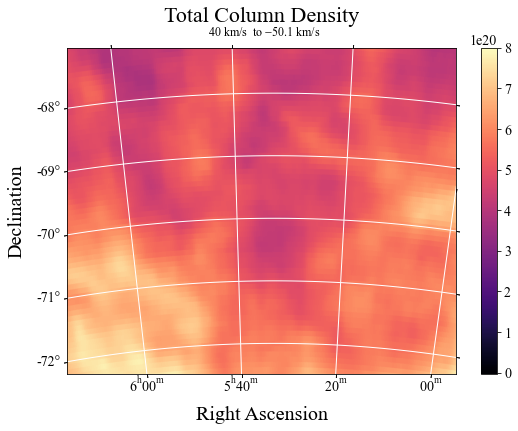

In [477]:
# column density over entire velocity range

col_dens(tot_col_dens, -0.25 * 10 ** 19,  0.8 * 10 ** 21, 'Total Column Density', '$\mathregular{40}$ km/s  to $\mathregular{-50.1}$ km/s')


In [479]:
tot_sum = np.sum(tot_col_dens, axis = 1)
tot_sum = tot_sum / np.linalg.norm(tot_sum)
GASKAP_tot_sum = np.sum(GASKAP_tot_cd.astype('float64'), axis = 1)
GASKAP_tot_sum = GASKAP_tot_sum / np.linalg.norm(GASKAP_tot_sum)

In [480]:
# correlation btwn total arrays

np.correlate(tot_sum, GASKAP_tot_sum)

array([0.9999942])

In [481]:
# correlation btwn HI and H2 pixels
HI_tot = col_dens_arr(pix_arr, tot_col_dens)
HI_tot = HI_tot / np.linalg.norm(HI_tot)
HI_tot_GASKAP = col_dens_arr(pix_arr, GASKAP_tot_cd)
HI_tot_GASKAP = HI_tot_GASKAP / np.linalg.norm(HI_tot_GASKAP)
np.correlate(HI_tot, HI_tot_GASKAP)

array([0.99999997])

CD1

In [482]:
col_dens1 = 1.82 * (10 ** 18) * np.nansum(HI4PI[0].data[v_indx(-1.06 * 10 ** 4):v_indx(1.06 * 10 ** 4)], axis = 0) * (1288.2149691242 * 10 ** -3) # in cm^-2
GASKAP_col_dens1 = 1.82 * (10 ** 18) * np.sum(GASKAP[0].data[v_indx_GASKAP(1.06 * 10 ** 4):v_indx_GASKAP(-1.06 * 10 ** 4)], axis = 0) * 0.244297870185
GASKAP_col_dens1 = process_usm(GASKAP_col_dens1, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering 


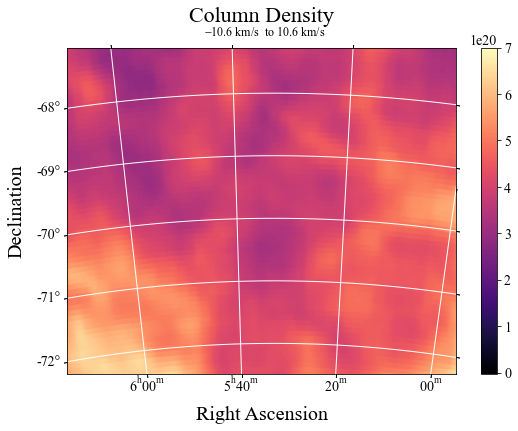

In [150]:
col_dens(col_dens1, -0.25 * 10 ** 19,  0.7 * 10 ** 21, 'Column Density', '$\mathregular{-10.6}$ km/s  to $\mathregular{10.6}$ km/s')


In [483]:
cd1_sum = np.sum(col_dens1, axis = 1)
cd1_sum = cd1_sum / np.linalg.norm(cd1_sum)
GASKAP_cd1_sum = np.sum(GASKAP_col_dens1.astype('float64'), axis = 1)
GASKAP_cd1_sum = GASKAP_cd1_sum / np.linalg.norm(GASKAP_cd1_sum)

In [484]:
# correlation btwn total arrays

np.correlate(cd1_sum, GASKAP_cd1_sum)

array([0.99998712])

In [485]:
# correlation btwn HI and H2 pixels
HI_cd1 = col_dens_arr(pix_arr, col_dens1)
HI_cd1 = HI_cd1 / np.linalg.norm(HI_cd1)
HI_cd1_GASKAP = col_dens_arr(pix_arr, GASKAP_col_dens1)
HI_cd1_GASKAP = HI_cd1_GASKAP / np.linalg.norm(HI_cd1_GASKAP)
np.correlate(HI_cd1, HI_cd1_GASKAP)

array([0.99999995])

CD2

In [486]:
col_dens2 = 1.82 * (10 ** 18) * np.sum(HI4PI[0].data[v_indx(-6.22 * 10 ** 3):v_indx(6.97 * 10 ** 3)], axis = 0) * (1288.2149691242 * 10 ** -3)
GASKAP_col_dens2 = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx_GASKAP(6.97 * 10 ** 3):v_indx_GASKAP(-6.22 * 10 ** 3)], axis = 0) * 0.244297870185 
GASKAP_col_dens2 = process_usm(GASKAP_col_dens2, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering 


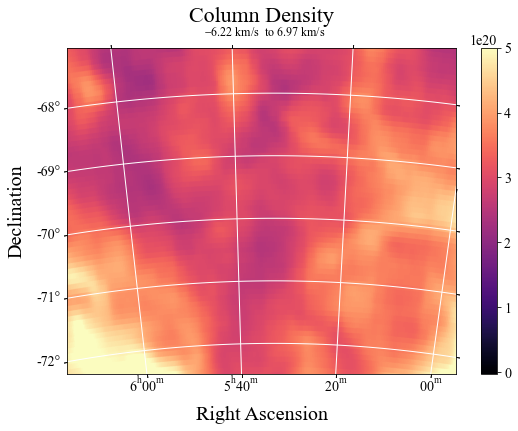

In [154]:
col_dens(col_dens2, -0.25 * 10 ** 19,  0.5 * 10 ** 21, 'Column Density', '$\mathregular{-6.22}$ km/s  to $\mathregular{6.97}$ km/s')


In [487]:
cd2_sum = np.sum(col_dens2, axis = 1)
cd2_sum = cd2_sum / np.linalg.norm(cd2_sum)
GASKAP_cd2_sum = np.nansum(GASKAP_col_dens2.astype('float64'), axis = 1)
GASKAP_cd2_sum = GASKAP_cd2_sum / np.linalg.norm(GASKAP_cd2_sum)

In [488]:
# correlation btwn total arrays

np.correlate(cd2_sum, GASKAP_cd2_sum)

array([0.99998758])

In [489]:
# correlation btwn HI and H2 pixels
HI_cd2 = col_dens_arr(pix_arr, col_dens2)
HI_cd2 = HI_cd2 / np.linalg.norm(HI_cd2)
HI_cd2_GASKAP = col_dens_arr(pix_arr, GASKAP_col_dens2)
HI_cd2_GASKAP = HI_cd2_GASKAP / np.linalg.norm(HI_cd2_GASKAP)
np.correlate(HI_cd2, HI_cd2_GASKAP)

array([0.99999994])

CD3

In [490]:
col_dens3 = 1.82 * (10 ** 18) * np.sum(HI4PI[0].data[v_indx(-4.29 * 10 ** 4):v_indx(-1.06 * 10 ** 4)], axis = 0) * (1288.2149691242 * 10 ** -3)
GASKAP_col_dens3 = 1.82 * (10 ** 18) * np.nansum(GASKAP[0].data[v_indx_GASKAP(-1.06 * 10 ** 4):v_indx_GASKAP(-4.29 * 10 ** 4)], axis = 0) * 0.244297870185 
GASKAP_col_dens3 = process_usm(GASKAP_col_dens3, FWHM = 16.2, file = GASKAP, low = True) # low-pass filtering 


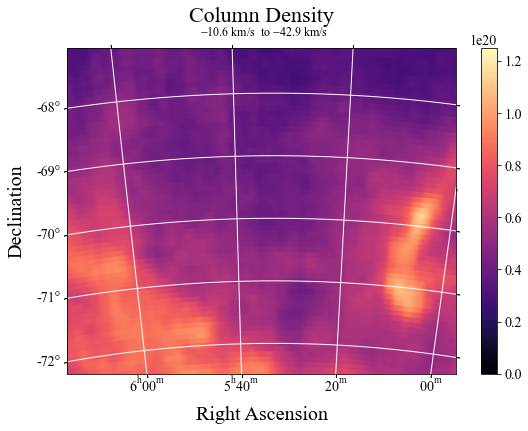

In [178]:
col_dens(col_dens3, 0,  1.25 * 10 ** 20, 'Column Density', '$\mathregular{-10.6}$ km/s  to $\mathregular{-42.9}$ km/s')


In [491]:
cd3_sum = np.sum(col_dens3, axis = 1)
cd3_sum = cd3_sum / np.linalg.norm(cd3_sum)
GASKAP_cd3_sum = np.nansum(GASKAP_col_dens3.astype('float64'), axis = 1)
GASKAP_cd3_sum = GASKAP_cd3_sum / np.linalg.norm(GASKAP_cd3_sum)

In [492]:
# correlation btwn total arrays

np.correlate(cd3_sum, GASKAP_cd3_sum)

array([0.99996256])

In [493]:
# correlation btwn HI and H2 pixels
HI_cd3 = col_dens_arr(pix_arr, col_dens3)
HI_cd3 = HI_cd3 / np.linalg.norm(HI_cd3)
HI_cd3_GASKAP = col_dens_arr(pix_arr, GASKAP_col_dens3)
HI_cd3_GASKAP = HI_cd3_GASKAP[np.where(np.isnan(HI_cd3_GASKAP) == False)]
HI_cd3_GASKAP = HI_cd3_GASKAP / np.linalg.norm(HI_cd3_GASKAP)
np.correlate(HI_cd3, HI_cd3_GASKAP)

array([0.99999986])

# (TOTAL) ALL H2 COLUMN DENSITY AGAINST INTEGRATED EMISSION

In [213]:
spearman_rank_integrated_tot = np.zeros((4, 2))
spearman_rank_integrated_tot_GASKAP = np.zeros((4, 2))

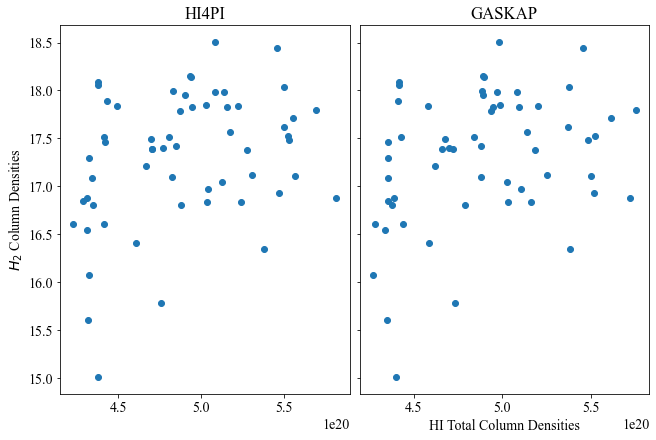

In [494]:
HI_CD_all_pix_tot, HI_CD_all_pix_tot_GASKAP, spearman_rank_integrated_tot[0,:], spearman_rank_integrated_tot_GASKAP[0,:] = HI_H2_integrated(tot_col_dens, GASKAP_tot_cd, SS = False, LS = False, log10 = False)



In [495]:
np.correlate(HI_CD_all_pix_tot / np.linalg.norm(HI_CD_all_pix_tot), HI_CD_all_pix_tot_GASKAP / np.linalg.norm(HI_CD_all_pix_tot_GASKAP))


array([0.99993668])

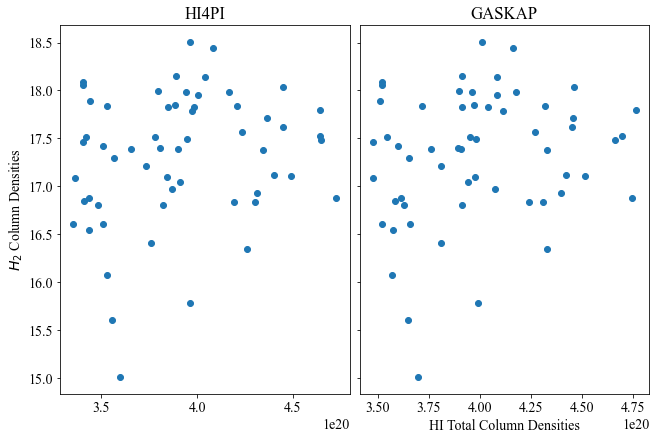

In [496]:
HI_CD_all_pix1, HI_CD_all_pix1_GASKAP, spearman_rank_integrated_tot[1,:], spearman_rank_integrated_tot_GASKAP[1,:] = HI_H2_integrated(col_dens1, GASKAP_col_dens1, SS = False, LS = False, log10 = False)


In [497]:
np.correlate(HI_CD_all_pix1 / np.linalg.norm(HI_CD_all_pix1), HI_CD_all_pix1_GASKAP / np.linalg.norm(np.linalg.norm(HI_CD_all_pix1_GASKAP)))



array([0.99989615])

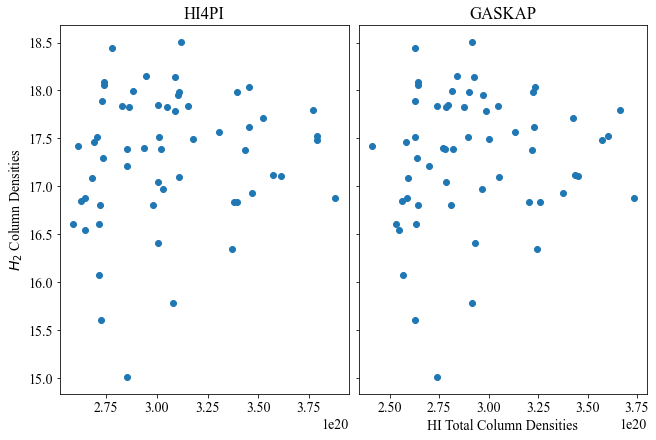

In [498]:
HI_CD_all_pix2, HI_CD_all_pix2_GASKAP, spearman_rank_integrated_tot[2,:], spearman_rank_integrated_tot_GASKAP[2,:] = HI_H2_integrated(col_dens2, GASKAP_col_dens2, SS = False, LS = False, log10 = False)



In [499]:
np.correlate(HI_CD_all_pix2 / np.linalg.norm(HI_CD_all_pix2), HI_CD_all_pix2_GASKAP / np.linalg.norm(np.linalg.norm(HI_CD_all_pix2_GASKAP)))



array([0.99987832])

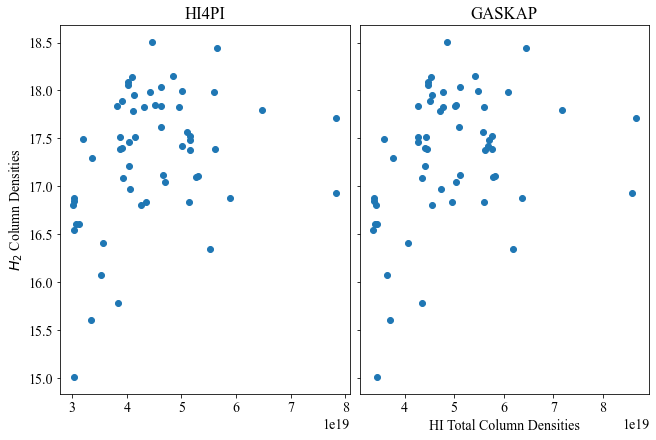

In [500]:
HI_CD_all_pix3, HI_CD_all_pix3_GASKAP, spearman_rank_integrated_tot[3,:], spearman_rank_integrated_tot_GASKAP[3,:] = HI_H2_integrated(col_dens3, GASKAP_col_dens3, SS = False, LS = False, log10 = False)



Less correlation here (GASKAP data seems to be noisier) . . .

In [501]:
np.correlate(HI_CD_all_pix3 / np.linalg.norm(HI_CD_all_pix3), HI_CD_all_pix3_GASKAP / np.linalg.norm(np.linalg.norm(HI_CD_all_pix3_GASKAP)))



array([0.99973295])

In [502]:
spearman_rank_integrated_tot

array([[0.32841652, 0.01183797],
       [0.19792356, 0.13640708],
       [0.19152503, 0.14980233],
       [0.35025763, 0.00703087]])

In [503]:
spearman_rank_integrated_tot_GASKAP

array([[0.31262112, 0.01688301],
       [0.18601003, 0.16211098],
       [0.14528284, 0.27653284],
       [0.35660894, 0.00600142]])

# (TOTAL) SELECT H2 COLUMN DENSITY (only where C/Cl measurements = available) AGAINST HI EMISSION @ SPECIFIC VELOCITIES

In [505]:
HI_CD_OE_tot, HI_CD_OE_tot_GASKAP = HI_H2_one(SS = False, LS = False, log10 = False)

In [506]:
np.correlate(HI_CD_OE_tot / np.linalg.norm(HI_CD_OE_tot), HI_CD_OE_tot_GASKAP / np.linalg.norm(HI_CD_OE_tot_GASKAP))

array([0.99590474])

Text(0.5, 1.0, 'GASKAP')

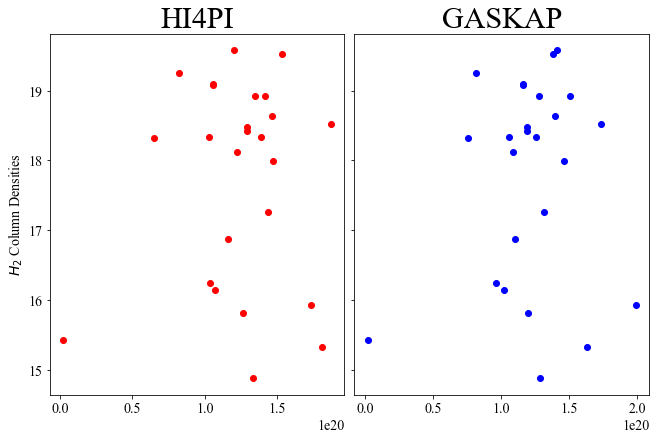

In [507]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, constrained_layout = True)
ax1.scatter(HI_CD_OE_tot, FUSE_replaced['total_log10_N'], c = 'red')
ax2.scatter(HI_CD_OE_tot_GASKAP, FUSE_replaced['total_log10_N'], c = 'blue')
ax1.set_ylabel('$H_2$ Column Densities')
ax1.set_title('HI4PI', fontsize = 30)
ax2.set_title('GASKAP', fontsize = 30)

In [508]:
spearman_rank_one_tot = stats.spearmanr(HI_CD_OE_tot, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
spearman_rank_one_tot_G = stats.spearmanr(HI_CD_OE_tot_GASKAP, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
print(spearman_rank_one_tot)
print(spearman_rank_one_tot_G)

SpearmanrResult(correlation=-0.03423735397051097, pvalue=0.8709358613465072)
SpearmanrResult(correlation=0.07923076923076922, pvalue=0.706571251745497)


# (SS) COLUMN DENSITY MAPS

In [509]:
tot_col_dens_SS = usm_cd(0, 70)

In [510]:
tot_col_dens_SSC = np.sum(tot_col_dens_SS, axis = 1)

In [511]:
tot_col_dens_SS_GASKAP = usm_cd_GASKAP(0, 300)

In [512]:
tot_col_dens_SSGC = np.sum(tot_col_dens_SS_GASKAP, axis = 1)

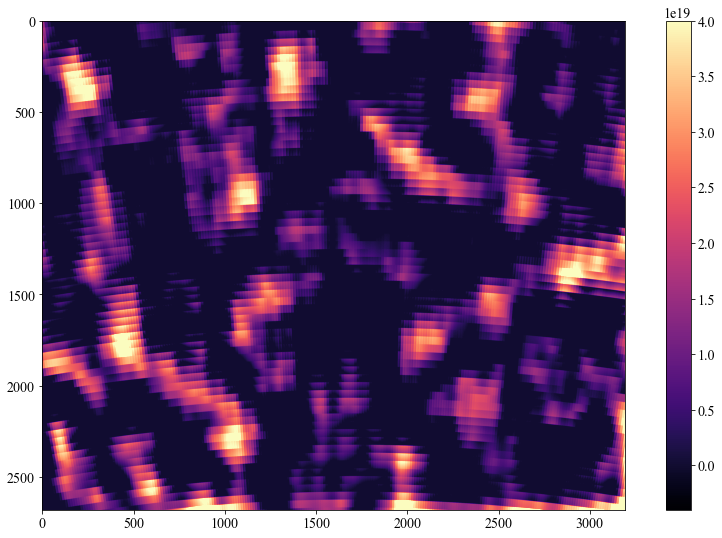

In [362]:
show_usm(tot_col_dens_SS, vmin = -0.4 * 10 ** 19, vmax = 0.4 * 10 ** 20)

In [513]:
# whole small-scale array
np.correlate(tot_col_dens_SSC / np.linalg.norm(tot_col_dens_SSC), tot_col_dens_SSGC / np.linalg.norm(tot_col_dens_SSGC))



array([0.99171409])

In [514]:
# correlation btwn HI and H2 pixels
HI_tot_SS = col_dens_arr(pix_arr, tot_col_dens_SS, log = False)
HI_tot_SS = HI_tot_SS / np.linalg.norm(HI_tot_SS)
HI_tot_SSG = col_dens_arr(pix_arr, tot_col_dens_SS_GASKAP, log = False)
HI_tot_SSG = HI_tot_SSG / np.linalg.norm(HI_tot_SSG)
np.correlate(HI_tot_SS, HI_tot_SSG)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_64298/1897631452.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens[i] = np.log10(col_dens)


array([0.95198678])

In [327]:
col_dens1_SS = usm_cd(v_indx(-1.06 * 10 ** 4), v_indx(1.06 * 10 ** 4))

In [317]:
col_dens1_SSC = np.sum(col_dens1_SS, axis = 1)

In [515]:
col_dens1_SS_GASKAP = usm_cd_GASKAP(81, 167)

In [516]:
col_dens1_SSGC = np.sum(col_dens1_SS_GASKAP, axis = 1)

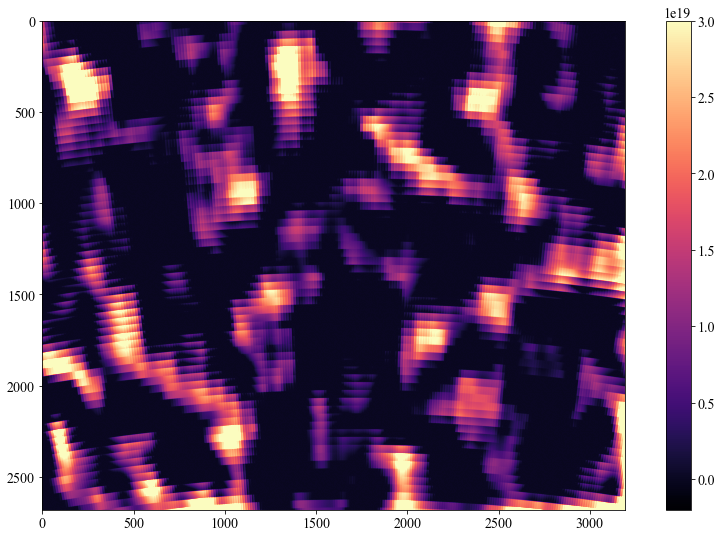

In [360]:
show_usm(col_dens1_SS, vmin = -0.2 * 10 ** 19, vmax = 0.3 * 10 ** 20)

Okay, somewhat better correlation here

In [517]:
# whole small-scale array
np.correlate(col_dens1_SSC / np.linalg.norm(col_dens1_SSC), col_dens1_SSGC / np.linalg.norm(col_dens1_SSGC))



array([0.9920509])

In [518]:
# correlation btwn HI and H2 pixels
HI_SS1 = col_dens_arr(pix_arr, col_dens1_SS, log = False)
HI_SS1 = HI_SS1 / np.linalg.norm(HI_SS1)
HI_SSG1 = col_dens_arr(pix_arr, col_dens1_SS_GASKAP, log = False)
HI_SSG1 = HI_SSG1 / np.linalg.norm(HI_SSG1)
np.correlate(HI_SS1, HI_SSG1)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_64298/1897631452.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens[i] = np.log10(col_dens)


array([0.92631345])

In [328]:
col_dens2_SS = usm_cd(v_indx(-6.22 * 10 ** 3), v_indx(6.97 * 10 ** 3))
col_dens2_SSC = np.sum(col_dens2_SS, axis = 1)

In [519]:
col_dens2_SS_GASKAP = usm_cd_GASKAP(95, 149)
col_dens2_SSGC = np.sum(col_dens2_SS_GASKAP, axis = 1)

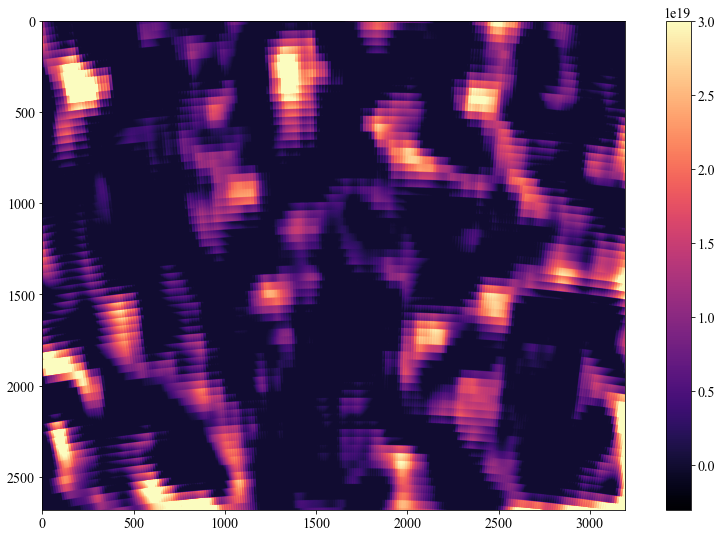

In [357]:
show_usm(col_dens2_SS,  vmin = -0.3 * 10 ** 19, vmax = 0.3 * 10 ** 20)

In [520]:
# whole small-scale array
np.correlate(col_dens2_SSC / np.linalg.norm(col_dens2_SSC), col_dens2_SSGC / np.linalg.norm(col_dens2_SSGC))



array([0.9924001])

In [521]:
# correlation btwn HI and H2 pixels
HI_SS2 = col_dens_arr(pix_arr, col_dens2_SS, log = False)
HI_SS2 = HI_SS2 / np.linalg.norm(HI_SS2)
HI_SSG2 = col_dens_arr(pix_arr, col_dens2_SS_GASKAP, log = False)
HI_SSG2 = HI_SSG2 / np.linalg.norm(HI_SSG2)
np.correlate(HI_SS2, HI_SSG2)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_64298/1897631452.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens[i] = np.log10(col_dens)


array([0.96251995])

In [341]:
col_dens3_SS = usm_cd(v_indx(-4.29 * 10 ** 4),v_indx(-1.06 * 10 ** 4))
col_dens3_SSC = np.sum(col_dens3_SS, axis = 1)

In [522]:
col_dens3_SS_GASKAP = usm_cd_GASKAP(167, 300)
col_dens3_SSGC = np.sum(col_dens3_SS_GASKAP, axis = 1)

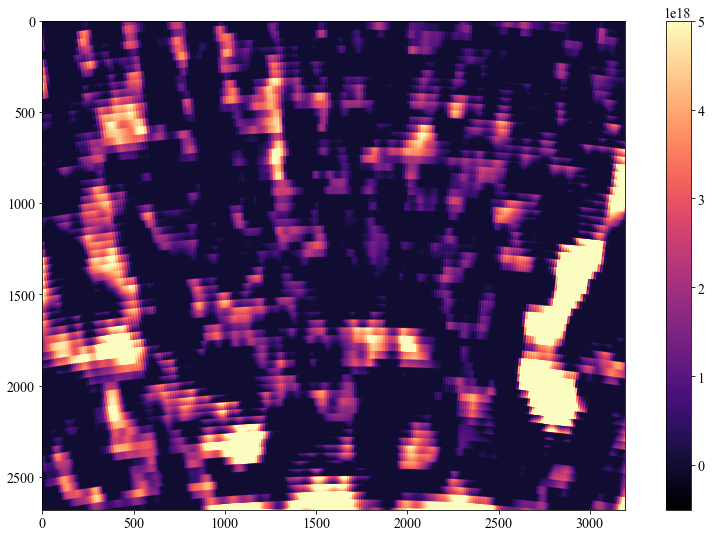

In [352]:
show_usm(col_dens3_SS, vmin = -0.05 * 10 ** 19, vmax = 0.5 * 10 ** 19)

In [523]:
# whole small-scale array
np.correlate(col_dens3_SSC / np.linalg.norm(col_dens3_SSC), col_dens3_SSGC / np.linalg.norm(col_dens3_SSGC))


array([0.99145148])

In [524]:
# correlation btwn HI and H2 pixels
HI_SS3 = col_dens_arr(pix_arr, col_dens3_SS, log = False)
HI_SS3 = HI_SS3 / np.linalg.norm(HI_SS3)
HI_SSG3 = col_dens_arr(pix_arr, col_dens3_SS_GASKAP, log = False)
HI_SSG3 = HI_SSG3 / np.linalg.norm(HI_SSG3)
np.correlate(HI_SS3, HI_SSG3)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_64298/1897631452.py:11: RuntimeWarning: divide by zero encountered in log10
  HI_col_dens[i] = np.log10(col_dens)


array([0.60476565])

# (SS) ALL H2 COLUMN DENSITY AGAINST INTEGRATED HI EMISSION

In [405]:
SR_integrated_SS = np.zeros((4, 2))
SR_integrated_SS_GASKAP = np.zeros((4, 2))

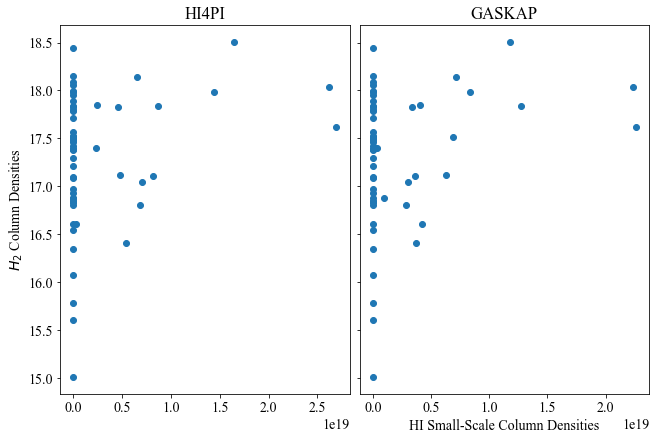

In [525]:
HI_SS_pix_tot, HI_SS_pix_tot_GASKAP, SR_integrated_SS[0,:], SR_integrated_SS_GASKAP[0,:] = HI_H2_integrated(tot_col_dens_SS, tot_col_dens_SS_GASKAP, LS = False, log10 = False)



In [526]:
np.correlate(HI_SS_pix_tot / np.linalg.norm(HI_SS_pix_tot), HI_SS_pix_tot_GASKAP / np.linalg.norm(HI_SS_pix_tot_GASKAP))



array([0.95198678])

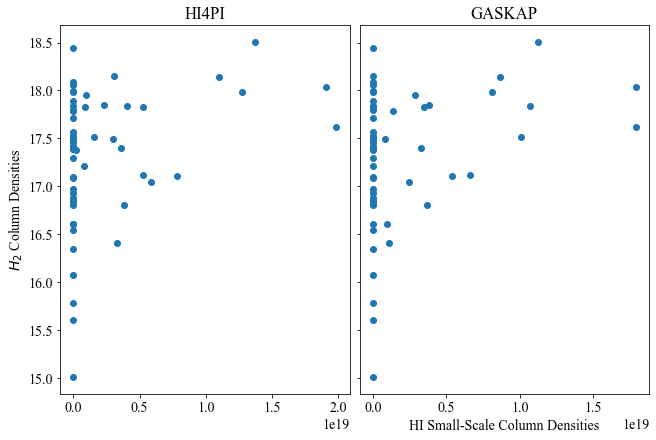

In [527]:
HI_SS_pix1, HI_SS_pix1_GASKAP, SR_integrated_SS[1,:], SR_integrated_SS_GASKAP[1,:] = HI_H2_integrated(col_dens1_SS, col_dens1_SS_GASKAP, LS = False, log10 = False)



In [528]:
np.correlate(HI_SS_pix1 / np.linalg.norm(HI_SS_pix1), HI_SS_pix1_GASKAP / np.linalg.norm(HI_SS_pix1_GASKAP))



array([0.92631345])

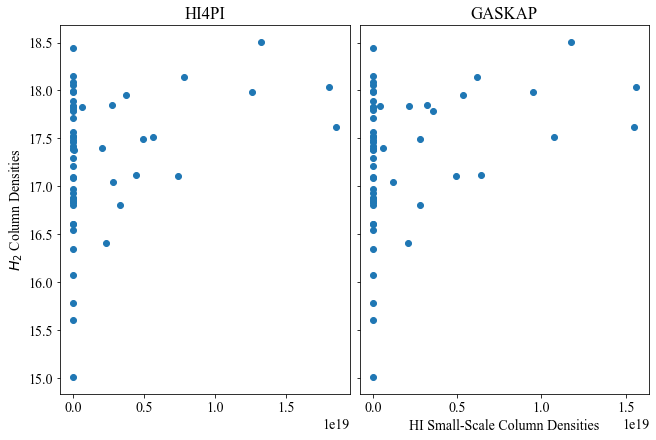

In [529]:
HI_SS_pix2, HI_SS_pix2_GASKAP, SR_integrated_SS[2,:], SR_integrated_SS_GASKAP[2,:] = HI_H2_integrated(col_dens2_SS, col_dens2_SS_GASKAP, LS = False, log10 = False)



In [530]:
np.correlate(HI_SS_pix2 / np.linalg.norm(HI_SS_pix2), HI_SS_pix2_GASKAP / np.linalg.norm(HI_SS_pix2_GASKAP))



array([0.96251995])

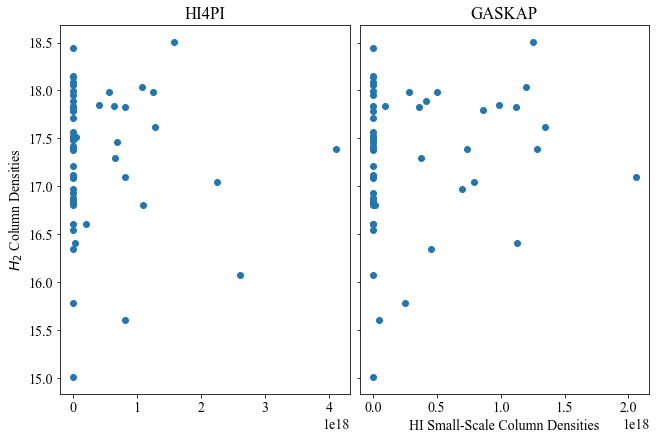

In [531]:
HI_SS_pix3, HI_SS_pix3_GASKAP, SR_integrated_SS[3,:], SR_integrated_SS_GASKAP[3,:] = HI_H2_integrated(col_dens3_SS, col_dens3_SS_GASKAP, LS = False, log10 = False)



In [532]:
np.correlate(HI_SS_pix3 / np.linalg.norm(HI_SS_pix3), HI_SS_pix3_GASKAP / np.linalg.norm(HI_SS_pix3_GASKAP))



array([0.60476565])

In [533]:
SR_integrated_SS

array([[0.18009483, 0.17612117],
       [0.3239702 , 0.01310576],
       [0.25177508, 0.05657769],
       [0.02473934, 0.85374996]])

In [534]:
SR_integrated_SS_GASKAP

array([[0.18231988, 0.17075157],
       [0.27046837, 0.04003087],
       [0.31540734, 0.01587872],
       [0.09975624, 0.45624508]])

# (SS) SELECT H2 COLUMN DENSITY (only where C/Cl measurements = available) AGAINST HI EMISSION @ SPECIFIC VELOCITIES

In [535]:
HI_CD_OE_SS, HI_CD_OE_SS_GASKAP = HI_H2_one(SS = True, LS = False, log10 = False)

In [536]:
HI_CD_OE_SS_log, HI_CD_OE_SS_GASKAP_log = HI_H2_one(SS = True, LS = False, log10 = True)

/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_64298/942479393.py:30: RuntimeWarning: divide by zero encountered in log10
  HI_cd_pix[i] = np.log10(HI_cd_all[int(pix_arr2[i][1])][int(pix_arr2[i][0])])
/var/folders/xk/1lmd1p057bnc571tp2ws6_sc0000gp/T/ipykernel_64298/942479393.py:31: RuntimeWarning: divide by zero encountered in log10
  HI_cd_pix_GASKAP[i] = np.log10(HI_cd_all_GASKAP[int(pix_arr2[i][1])][int(pix_arr2[i][0])])


In [537]:
np.correlate(HI_CD_OE_SS / np.linalg.norm(HI_CD_OE_SS), HI_CD_OE_SS_GASKAP / np.linalg.norm(HI_CD_OE_SS_GASKAP))



array([0.94915475])

Text(0.5, 1.0, 'GASKAP')

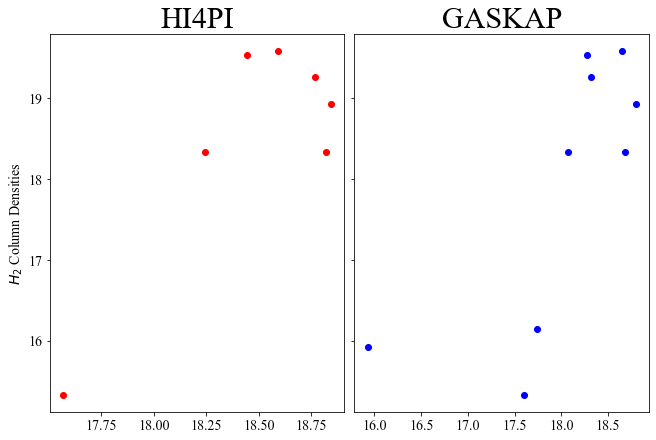

In [538]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey = True, constrained_layout = True)
ax1.scatter(HI_CD_OE_SS_log, FUSE_replaced['total_log10_N'], c = 'red')
ax2.scatter(HI_CD_OE_SS_GASKAP_log, FUSE_replaced['total_log10_N'], c = 'blue')
ax1.set_ylabel('$H_2$ Column Densities')
ax1.set_title('HI4PI', fontsize = 30)
ax2.set_title('GASKAP', fontsize = 30)

In [539]:
spearman_rank_one_SS = stats.spearmanr(HI_CD_OE_SS, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
spearman_rank_one_SS_G = stats.spearmanr(HI_CD_OE_SS_GASKAP, FUSE_replaced['total_log10_N'], nan_policy = 'omit')
print(spearman_rank_one_SS)
print(spearman_rank_one_SS_G)

SpearmanrResult(correlation=0.3986846386767655, pvalue=0.048371374585012936)
SpearmanrResult(correlation=0.2783896572828295, pvalue=0.1778181050464346)


# (LS) COLUMN DENSITY MAPS

In [540]:
tot_col_dens_LS = tot_col_dens - tot_col_dens_SS
tot_col_dens_LS_GASKAP = GASKAP_tot_cd - tot_col_dens_SS_GASKAP

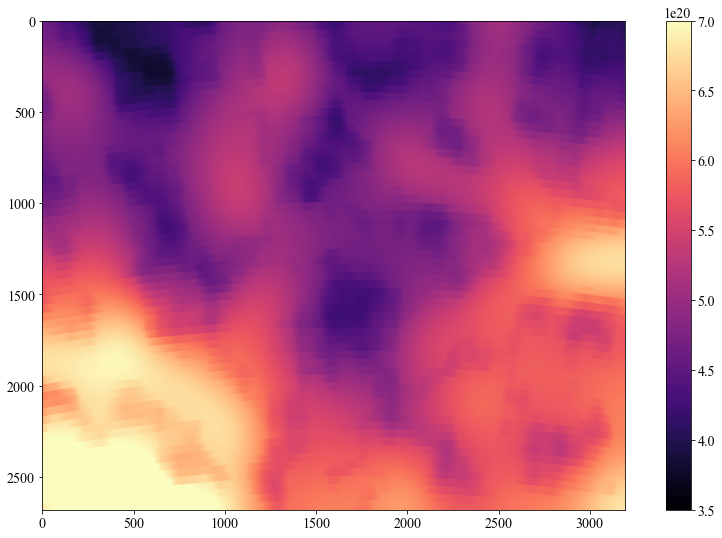

In [433]:
show_usm(tot_col_dens_LS, vmin = 3.5 * 10 ** 20, vmax = 7 * 10 ** 20)

In [541]:
col_dens1_LS = col_dens1 - col_dens1_SS
col_dens1_LS_GASKAP = GASKAP_col_dens1 - col_dens1_SS_GASKAP

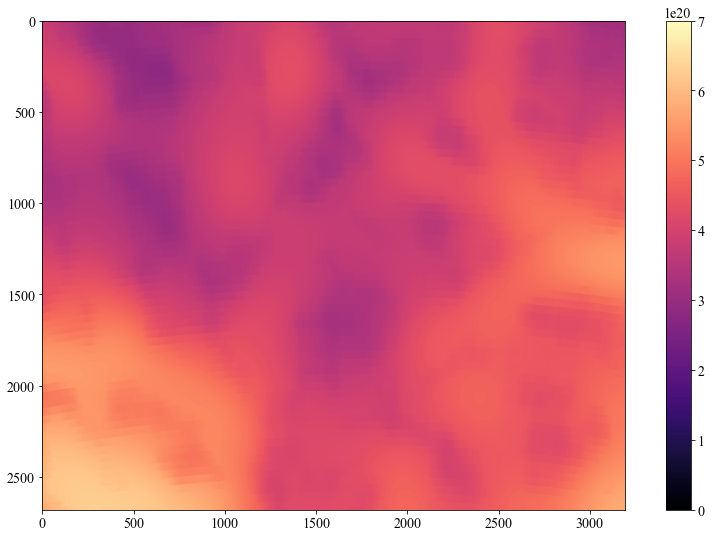

In [436]:
show_usm(col_dens1_LS, vmax = 7 * 10 ** 20)

In [542]:
col_dens2_LS = col_dens2 - col_dens2_SS
col_dens2_LS_GASKAP = GASKAP_col_dens2 - col_dens2_SS_GASKAP

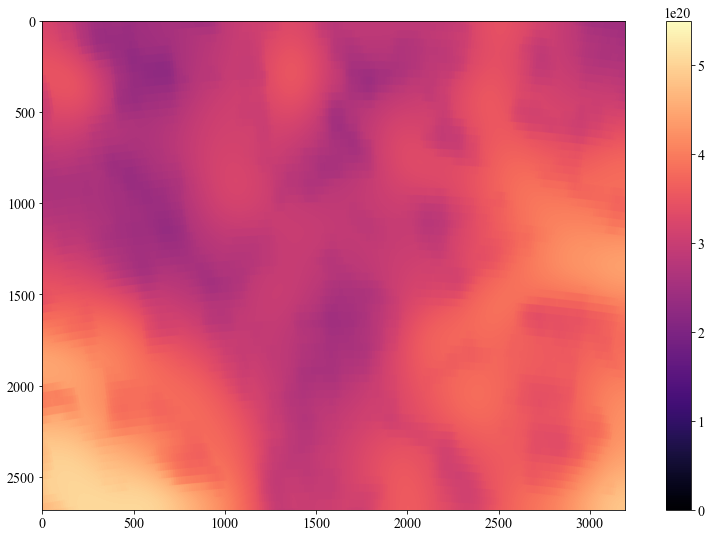

In [440]:
show_usm(col_dens2_LS, vmax = 5.5 * 10 ** 20)

In [543]:
col_dens3_LS = col_dens3 - col_dens3_SS
col_dens3_LS_GASKAP = GASKAP_col_dens3 - col_dens3_SS_GASKAP

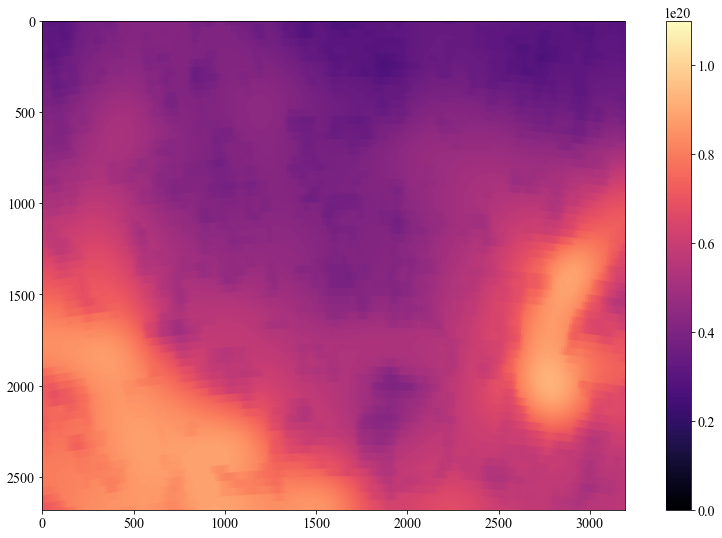

In [443]:
show_usm(col_dens3_LS, vmax = 1.1 * 10 ** 20)

# (LS) ALL H2 COLUMN DENSITY AGAINST INTEGRATED HI EMISSION

In [544]:
SR_integrated_SS = np.zeros((4, 2))
SR_integrated_LS_GASKAP = np.zeros((4, 2))

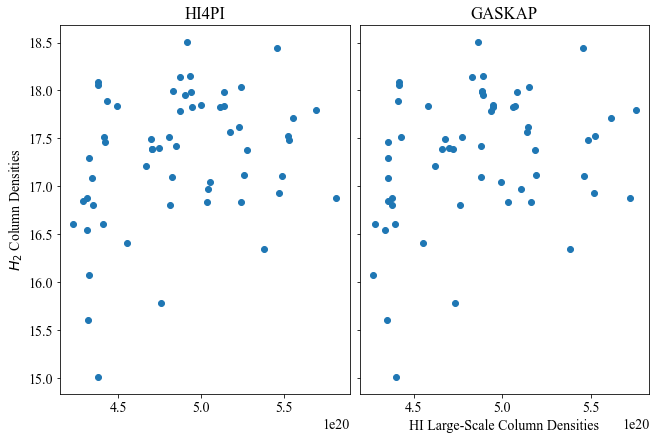

In [545]:
HI_LS_pix_tot, HI_LS_pix_tot_GASKAP, SR_integrated_LS[0,:], SR_integrated_LS_GASKAP[0,:] = HI_H2_integrated(tot_col_dens_LS, tot_col_dens_LS_GASKAP, SS = False, LS = True, log10 = False)



In [546]:
np.correlate(HI_LS_pix_tot / np.linalg.norm(HI_LS_pix_tot), HI_LS_pix_tot_GASKAP / np.linalg.norm(HI_LS_pix_tot_GASKAP))

array([0.99995211])

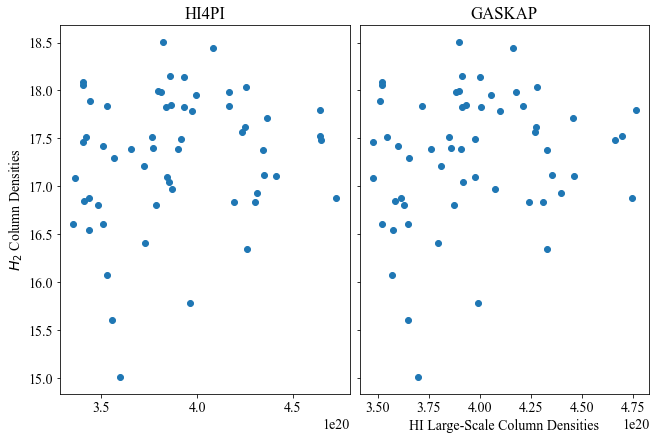

In [547]:
HI_LS_pix1, HI_LS_pix1_GASKAP, SR_integrated_LS[1,:], SR_integrated_LS_GASKAP[1,:] = HI_H2_integrated(col_dens1_LS, col_dens1_LS_GASKAP, SS = False, LS = True, log10 = False)



In [548]:
np.correlate(HI_LS_pix1 / np.linalg.norm(HI_LS_pix1), HI_LS_pix1_GASKAP / np.linalg.norm(HI_LS_pix1_GASKAP))



array([0.99991117])

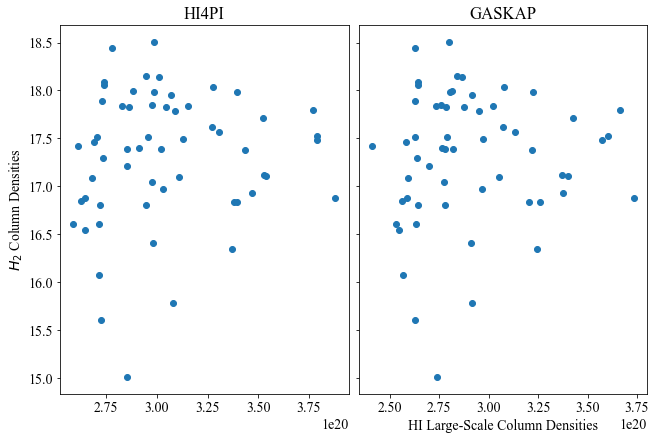

In [549]:
HI_LS_pix2, HI_LS_pix2_GASKAP, SR_integrated_LS[2,:], SR_integrated_LS_GASKAP[2,:] = HI_H2_integrated(col_dens2_LS, col_dens2_LS_GASKAP, SS = False, LS = True, log10 = False)



In [550]:
np.correlate(HI_LS_pix2 / np.linalg.norm(HI_LS_pix2), HI_LS_pix2_GASKAP / np.linalg.norm(HI_LS_pix2_GASKAP))



array([0.99989177])

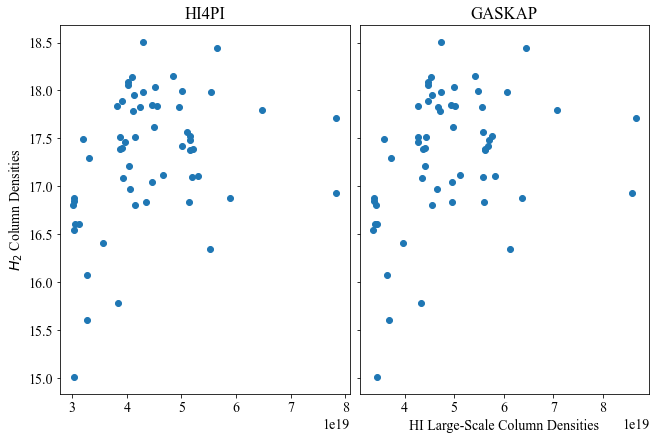

In [551]:
HI_LS_pix3, HI_LS_pix3_GASKAP, SR_integrated_LS[3,:], SR_integrated_LS_GASKAP[3,:] = HI_H2_integrated(col_dens3_LS, col_dens3_LS_GASKAP, SS = False, LS = True, log10 = False)



In [552]:
np.correlate(HI_LS_pix3 / np.linalg.norm(HI_LS_pix3), HI_LS_pix3_GASKAP / np.linalg.norm(HI_LS_pix3_GASKAP))



array([0.99987003])

# (LS) SELECT H2 COLUMN DENSITY (only where C/Cl measurements = available) AGAINST HI EMISSION @ SPECIFIC VELOCITIES

In [553]:
HI_CD_OE_LS, HI_CD_OE_LS_GASKAP = HI_H2_one(SS = False, LS = True, log10 = False)

In [ ]:
plt.scatter(np.log10(HI_CD_OE_LS), FUSE_replaced_no['total_log10_N'], c = 'red')
plt.xlabel('HI Large-Scale Column Densities')
plt.ylabel('$H_2$ Column Densities')
plt.title('Using C/Cl Velocities', fontsize = 30)

ValueError: x and y must be the same size

In [ ]:
# removing outliers
HI_CD_OE_LS = np.delete(HI_CD_OE_LS, 17) 
FUSE_replaced_no = FUSE_replaced.drop(137)

In [ ]:
# gets spearman rank coefficient the velocity-centered plot above 
spearman_rank_one_LS = stats.spearmanr(HI_CD_OE_LS, FUSE_replaced_no['total_log10_N'], nan_policy = 'omit')
print(spearman_rank_one_LS)